In [12]:
import gym
from scipy.special import hyp2f1
from numpy.random import rand
from numpy.linalg import norm
from numpy import array
from numpy import inf
from numpy import conj,linspace,meshgrid,logical_and
from numpy import abs as np_abs
import matplotlib.pyplot as plt
import torch as th
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [13]:
th.autograd.set_detect_anomaly(True)

## Sampling ##
As suggested by <a href="https://arxiv.org/pdf/1606.02771.pdf">The Effective Bootstrap</a> Sec.3.1

In [14]:
def rho(z):
    return z/(1+(1-z)**(1/2))**2

def llambda(z):
    return abs(rho(z))+abs(rho(1-z))

In [15]:
Nx = 25
Ny = 25
x = linspace(-1,2,Nx)
y = linspace(-2,2,Ny)
xv, yv = meshgrid(x,y)
zv = xv+1j*yv

In [16]:
lambda_c = 0.6
z = zv.flatten()
lz=llambda(z)
z = z[logical_and(logical_and(lz<lambda_c,z.real>=1/2),z.imag>=0)]
Nz = z.size
pts=[[p,conj(p)] for p in z]

Text(0, 0.5, 'Im(z)')

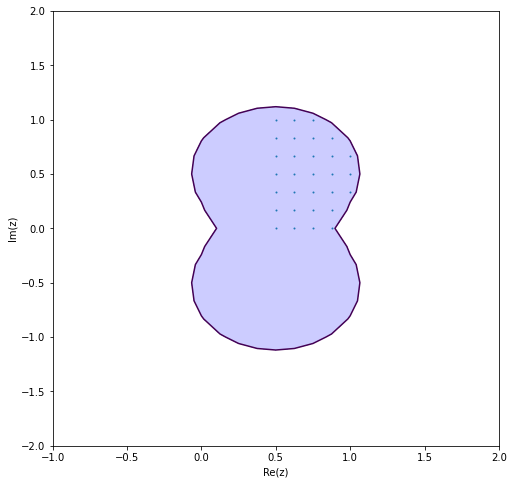

In [17]:
plt.figure(figsize=[8,8])
plt.contour(xv, yv, llambda(zv),[lambda_c])
plt.contourf(xv, yv, llambda(zv),[0,lambda_c],alpha=.2,colors='blue')
plt.scatter(z.real,z.imag,s=1)
plt.xlabel('Re(z)')
plt.ylabel('Im(z)')

## Model ##

In [18]:
spins = array([0,0,2,4,6])
ex_h = [[3/80,3/80] for i in range(4)]
accuracy_threshold = 10**-3
reward_scale=0.005

In [19]:
# pts = rand(29,2)

In [20]:
def g(h,hb,z,zb):
    h12=ex_h[0][0]-ex_h[1][0]
    h34=ex_h[2][0]-ex_h[3][0]
    hb12=ex_h[0][1]-ex_h[1][1]
    hb34=ex_h[2][1]-ex_h[3][1]
    output = (1/2 if h==hb else 1)*(z**h*zb**hb*hyp2f1(h-h12,h+h34,2*h,z)*hyp2f1(hb-hb12,hb+hb34,2*hb,zb)+ \
                                    zb**h*z**hb*hyp2f1(h-h12,h+h34,2*h,zb)*hyp2f1(hb-hb12,hb+hb34,2*hb,z))
#     print('g=',output)
    return output

def p(h,hb,c,z,zb):
    output = c*(((z-1)*(zb-1))**(1/8)*g(h,hb,z,zb)-z**(1/8)*zb**(1/8)*g(h,hb,1-z,1-zb))
#     print('p=',output)
    return output

In [22]:
def e(spec,pts):
    output= [(sum([p(n[0],n[1],n[2],z[0],z[1]) for n in spec if n[0]>=n[1]]) + \
              ((z[0]-1)*(z[1]-1))**(1/8)-z[0]**(1/8)*z[1]**(1/8)) for z in pts]
#     print('e=',output)
    return output

In [24]:
def e_abs(spec,pts):
    output= sum([(sum(np_abs([p(n[0],n[1],n[2],z[0],z[1]) for n in spec if n[0]>=n[1]])) + \
                  ((z[0]-1)*(z[1]-1))**(1/8)-z[0]**(1/8)*z[1]**(1/8)) for z in pts])
#     print('e_abs=',output)
    return output

In [25]:
def A(spec,pts):
    output = norm(e(spec,pts))/e_abs(spec,pts)
#     print('A=',output)
    return output

In [26]:
test_obs = array([4,2.44141*10**-4,1,0.25,2,0.015625,4,2.19727*10**-4,6,1.36239*10**-5])
test_spec = [[(test_obs[2*i]+spins[i])/2, (test_obs[2*i]-spins[i])/2, test_obs[2*i+1]]for i in range(5)]

In [27]:
norm(e(test_spec,pts))

2.9204964057933857e+29

In [28]:
class IsingEnv(gym.Env):
    def __init__(self):
#         self.state=rand(10)
        self.state=test_obs
        self.action_space = gym.spaces.Box(array([-1 for i in range(10)],dtype='float32'), array([1 for i in range(10)],dtype='float32'))
        self.observation_space = gym.spaces.Box(array([-10 for i in range(10)]),array([10 for i in range(10)]))
        self.n = 5
        self.best_reward=-inf
    def reset(self):
        self.state=test_obs
#         self.state=rand(10)
        return self._next_observation()
    def _next_observation(self):
        return self.state
    def step(self, action):
        self._take_action(action)
#         print(self.state)
        done = False
        obs = self._next_observation()
        spec = [[(obs[2*i]+spins[i])/2, (obs[2*i]-spins[i])/2, obs[2*i+1]]for i in range(self.n)]
        reward = -norm(e(spec, pts))*reward_scale
#         print(reward)
        if reward>self.best_reward :
            self.best_reward = reward
            print('best_reward=',self.best_reward)
            done=True
        info = {}
        return obs, reward, done, info
    def _take_action(self,action):
        self.state=self.state+action

class IsingEnv2(gym.Env):
    def __init__(self):
        self.state=rand(10)
        self.action_space = gym.spaces.Box(array([-10 for i in range(10)],dtype='float32'), array([10 for i in range(10)],dtype='float32'))
        self.observation_space = gym.spaces.Box(array([-10 for i in range(10)]),array([10 for i in range(10)]))
        self.n = 5
        self.best_reward=-inf
    def reset(self):
        self.state=rand(10)
        return self._next_observation()
    def _next_observation(self):
        return self.state
    def step(self, action):
        self._take_action(action)
        done = False
        obs = self._next_observation()
        spec = [[(obs[2*i]+spins[i])/2, (obs[2*i]-spins[i])/2, obs[2*i+1]]for i in range(self.n)]
        reward = -norm(e(spec, pts))
#         print(reward)
        if reward>self.best_reward :
            self.best_reward = reward
#             print('best_reward=',self.best_reward)
            done=True
        info = {}
        return obs, reward, done, info
    def _take_action(self,action):
        self.state=action
    def _get_accuracy(self):
        obs = self._next_observation()
        spec = [[(obs[2*i]+spins[i])/2, (obs[2*i]-spins[i])/2, obs[2*i+1]]for i in range(self.n)]
        return A(spec,pts)

## Learning ##

In [29]:
from stable_baselines3 import SAC
from stable_baselines3.common.callbacks import EventCallback,BaseCallback

In [30]:
class StopTrainingOnAccuracyThreshold(BaseCallback):
    def __init__(self, accuracy_threshold: float, verbose: int = 0):
        super(StopTrainingOnAccuracyThreshold, self).__init__(verbose=verbose)
        self.accuracy_threshold = accuracy_threshold

    def _on_step(self) -> bool:
        assert self.parent is not None, "``StopTrainingOnAccuracyThreshold`` callback must be used " "with an ``AccuracyCallback``"
        continue_training = bool(self.parent.accuracy > self.accuracy_threshold)
        if self.verbose > 0 and not continue_training:
            print(
                f"Stopping training because the accuracy {self.parent.accuracy:f} "
                f" is below the threshold {self.accuracy_threshold}"
            )
        return continue_training

In [31]:
# ising= IsingEnv2()
# model = SAC("MlpPolicy", ising, learning_rate=5e-4, buffer_size=100000, learning_starts=1000, batch_size=64, \
#             tau=0.001, gamma= 0.99, verbose=1, device='cuda')
# model.get_env().env_method('_get_accuracy')

In [35]:
ising= IsingEnv2()
model = SAC("MlpPolicy", ising, learning_rate=5e-4, buffer_size=100000, learning_starts=1000, batch_size=64, \
            tau=0.001, gamma= 0.99, verbose=1, device='cuda')
model.learn(total_timesteps=100000, log_interval=4)
model.save("Ising_baselines")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
best_reward= -25015683341888.08
best_reward= -1112712.0122614712
best_reward= -515617.9336581758
best_reward= -5698.103977992241
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 5.5       |
|    ep_rew_mean     | -2.39e+18 |
| time/              |           |
|    episodes        | 4         |
|    fps             | 105       |
|    time_elapsed    | 0         |
|    total_timesteps | 22        |
----------------------------------
best_reward= -5040.426035704121
best_reward= -2791.321046330525
best_reward= -454.5834845697232
best_reward= -407.37137132120125
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 616       |
|    ep_rew_mean     | -6.82e+20 |
| time/              |           |
|    episodes        | 8         |
|    fps             | 9         |
|    time_elapsed    | 545       |
|    total_timeste